In [35]:
import cv2
import mediapipe as mp
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_hands.HAND_CONNECTIONS) # Draw left hand connections
    #mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_hands.HAND_CONNECTIONS) # Draw right hand connections
    
    if results.multi_hand_landmarks: # if there is at least one hand
        for num, hand in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing_styles.get_default_hand_landmarks_style(),
                                      mp_drawing_styles.get_default_hand_connections_style()
                                      #mp_drawing.DrawingSpec(color=(121, 22,  76), thickness=2, circle_radius=4),
                                      #mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                      )

In [7]:
# results.multi_hand_landmarks[0].landmark
def extract_keypoints(results):
    h = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3) # se non trovi la mano, mettici tutti 0, 3 coordinate per 21 joints
    return h #np.concatenate([pose, face, lh, rh]) questo potrà essere utile per gestire più mani

#NUM_FEATURES_PER_FRAME = len(extract_keypoints(results))
NUM_FEATURES_PER_FRAME = 63

In [28]:
def extract_keypoints_from_video(video_path):

    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Get the video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a numpy array to store the keypoints
    keypoints = np.zeros((frame_count, NUM_FEATURES_PER_FRAME))

    # Set mediapipe model
    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        for frame_num in range(frame_count):

            # Read feed
            ret, frame = cap.read()

            # Break if problem reading frame
            if not ret:
                print("Error reading frame {}".format(frame_num + 1))
                return None

            # Make detections
            image, results = mediapipe_detection(frame, hands)

            # Draw landmarks
            draw_landmarks(image, results)
            
            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Check if excatly one hand is detected and save keypoints
            if results.multi_hand_landmarks is not None and len(results.multi_hand_landmarks) == 1:
                keypoints[frame_num] = extract_keypoints(results)
            # Otherwise, if no hand is detected, return None
            else:
                return None

            # Break gracefully
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

    return keypoints
   

In [32]:
keypoints = extract_keypoints_from_video(str(Path("dataset_creation/4_videos_labeled_subsampled/1/vid_00097_00022.mov")))

In [ ]:
#np.save(npy_path, keypoints)

In [33]:
keypoints.shape

(30, 63)

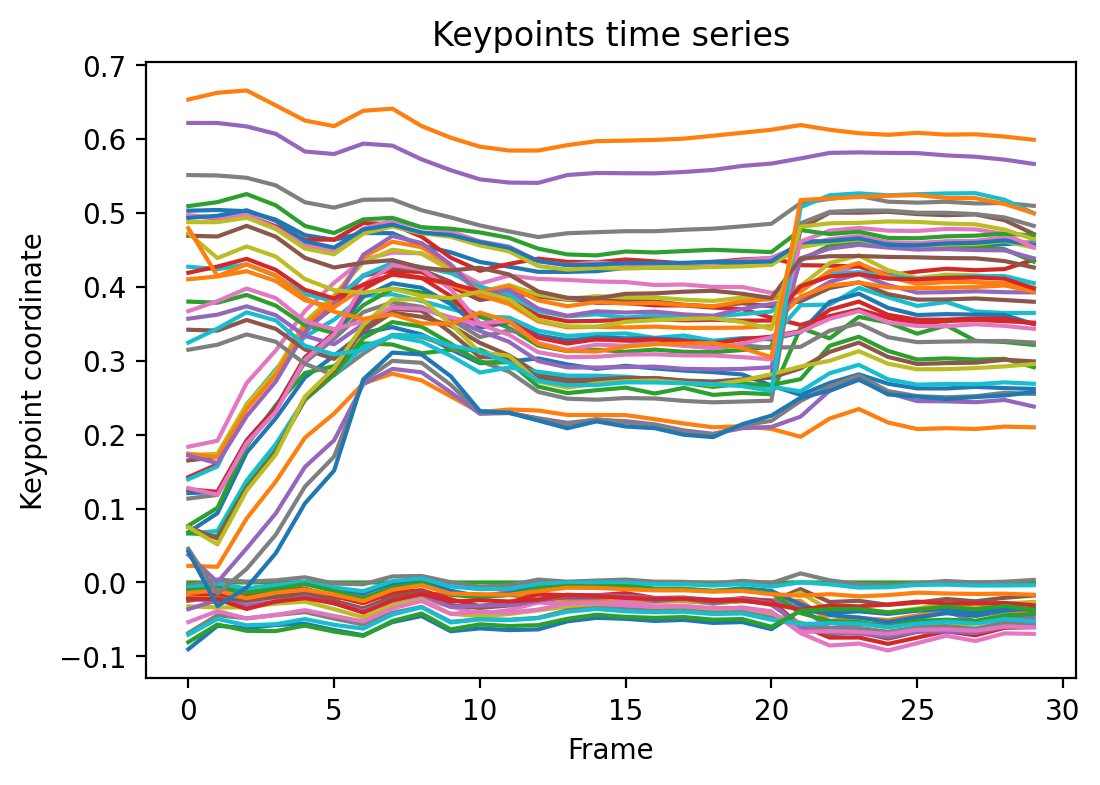

: 

In [47]:
# Plot keypoints
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(keypoints[:,:])
ax.set_title("Keypoints time series")
ax.set_xlabel("Frame")
ax.set_ylabel("Keypoint coordinate")
plt.show()